In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import os

In [5]:
data = pd.read_excel('C:/Users/test/Downloads/Book1.xlsx')

In [6]:
data = data.set_index('Country')

In [7]:
data

,N,I,O,rgdpw90,rgdpw15,gdpgrowth,popgrowth,saving rate,school
Country,,,,,,,,,
Angola,1,0,0,5446.113163,14880.971987,0.041027,0.033637,0.671021,1.314978
Benin,1,0,0,3645.470495,8055.181996,0.032221,0.029769,0.345713,1.458790
Botswana,1,1,0,22282.811487,39399.592753,0.023059,0.021241,0.340820,2.184608
Burkina Faso,1,0,0,2420.686988,5051.750882,0.029865,0.028324,0.188617,1.107227
Burundi,1,0,0,1931.922447,1826.186235,-0.002249,0.024637,0.109714,1.235173
...,...,...,...,...,...,...,...,...,...
Venezuela,1,1,0,28912.334555,11764.632233,-0.035328,0.017177,0.064763,2.272504
Australia,1,1,1,62708.409870,96665.358576,0.017461,0.013708,0.312089,3.474760
Fiji,0,0,0,17668.626025,34974.549829,0.027690,0.006940,0.268472,2.458378


In [8]:
data['logngd'] = np.log(data['popgrowth']/100 + 0.05)
data['logs'] = np.log(data['saving rate']/100)
data['const'] = 1
data['logs_logngd'] = data['logs'] - data['logngd']

In [10]:
data['logschool'] = np.log(data['school'])
data['logsch_ngd'] = data['logschool'] - data['logngd']
data['logy60'] = np.log(data['rgdpw90'])
data['logy85'] = np.log(data['rgdpw15'])
data['loginv'] = np.log(data['saving rate'])

#subsetting data
data_reg = data.loc[data['N'] == 1, :] #no oil
data_d = data_reg[data_reg.I == 1] #pop in 1960 less than 1 mil
data_oecd = data_reg[data_reg.O == 1] #oecd

In [11]:
#no restrictions on coefficients here
reg1 = sm.OLS(endog = data_reg['logy85'],
              exog = data_reg[['const', 'logs', 'logngd']],
             missing = 'drop').fit()

reg2 = sm.OLS(endog = data_d['logy85'],
             exog = data_d[['const', 'logs', 'logngd']],
             missing = 'drop').fit()

reg3 = sm.OLS(endog = data_oecd['logy85'],
             exog = data_oecd[['const', 'logs', 'logngd']],
             missing = 'drop').fit()

In [12]:
#coeff(log(savings)) = -coeff(log(n+g+d))
regr1 = sm.OLS(endog = data_reg['logy85'],
             exog = data_reg[['const', 'logs_logngd']],
             missing = 'drop').fit()

regr2 = sm.OLS(endog = data_d['logy85'],
             exog = data_d[['const', 'logs_logngd']],
             missing = 'drop').fit()

regr3 = sm.OLS(endog = data_oecd['logy85'],
             exog = data_oecd[['const', 'logs_logngd']],
             missing = 'drop').fit()


In [13]:
info_dict = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1]):.2f}"}

results_unres = summary_col(results = [reg1, reg2, reg3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dict,
                           regressor_order = ['const',
                                             'logs',
                                             'logngd'])


results_res = summary_col(results = [regr1, regr2, regr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dict,
                           regressor_order = ['const',
                                             'logs',
                                             'logs_lngd'])


results_res.add_title('Restricted Regressions')
results_unres.add_title('Unrestricted Regressions')
print(results_unres)
print('')
print(results_res)

            Unrestricted Regressions
                 Non-Oil   Intermediate   OECD  
------------------------------------------------
const          -1236.49*** -1030.17***  201.35  
               (143.53)    (158.14)     (187.01)
logs           0.91***     0.55**       0.06    
               (0.21)      (0.22)       (0.25)  
logngd         -418.37***  -348.79***   63.29   
               (47.95)     (52.87)      (62.30) 
R-squared      0.57        0.44         0.05    
R-squared Adj. 0.56        0.42         -0.05   
R^2            0.5579      0.4246       -0.0478 
N              77.0000     63.0000      22.0000 
s.e.e.         0.7473      0.6707       0.2198  
Implied α      0.48        0.36         0.06    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

           Restricted Regressions
               Non-Oil  Intermediate   OECD  
---------------------------------------------
const          13.02*** 11.86***     11.42***
               (0.82)   (0.77)       (0.64)  

In [14]:
#no restrictions on coefficients here
regh1 = sm.OLS(endog = data_reg['logy85'],
             exog = data_reg[['const', 'logs', 'logngd', 'logschool']],
             missing = 'drop').fit()

regh2 = sm.OLS(endog = data_d['logy85'],
             exog = data_d[['const', 'logs', 'logngd', 'logschool']],
             missing = 'drop').fit()

regh3 = sm.OLS(endog = data_oecd['logy85'],
             exog = data_oecd[['const', 'logs', 'logngd', 'logschool']],
             missing = 'drop').fit()

In [15]:
#coeff(log(savings)) = -coeff(log(n+g+d))
reghr1 = sm.OLS(endog = data_reg['logy85'],
             exog = data_reg[['const', 'logs_logngd', 'logsch_ngd']],
             missing = 'drop').fit()

reghr2 = sm.OLS(endog = data_d['logy85'],
             exog = data_d[['const', 'logs_logngd', 'logsch_ngd']],
             missing = 'drop').fit()

reghr3 = sm.OLS(endog = data_oecd['logy85'],
             exog = data_oecd[['const', 'logs_logngd', 'logsch_ngd']],
             missing = 'drop').fit()

In [25]:
info_dictu = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1] + x.params[3]):.2f}",
            'Implied β': lambda x: f"{x.params[3]/(1 + x.params[1] + x.params[3]):.2f}"}

info_dictr = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1] + x.params[2]):.2f}",
            'Implied β': lambda x: f"{x.params[2]/(1 + x.params[1] + x.params[2]):.2f}"}

results_unres = summary_col(results = [regh1, regh2, regh3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictu,
                           regressor_order = ['const',
                                             'logs',
                                             'logngd',
                                             'logschool'])


results_res = summary_col(results = [reghr1, reghr2, reghr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictr,
                           regressor_order = ['const',
                                             'logs',
                                             'logs_logngd',
                                             'logsch_ngd'])
results_res.add_title('Restricted Regressions')
results_unres.add_title('Unrestricted Regressions')
print(results_unres)
print('')
print(results_res)

          Unrestricted Regressions
               Non-Oil  Intermediate   OECD  
---------------------------------------------
const          -244.36* -327.28**    380.10**
               (135.53) (133.23)     (163.09)
logs           0.64***  0.62***      0.71**  
               (0.14)   (0.15)       (0.29)  
logngd         -85.63*  -113.27**    122.20**
               (45.37)  (44.58)      (54.26) 
logschool      2.59***  2.60***      1.19*** 
               (0.26)   (0.30)       (0.37)  
R-squared      0.82     0.76         0.40    
R-squared Adj. 0.81     0.74         0.30    
R^2            0.8130   0.7427       0.2962  
N              77.0000  63.0000      22.0000 
s.e.e.         0.4860   0.4484       0.1802  
Implied α      0.15     0.15         0.24    
Implied β      0.61     0.62         0.41    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

          Restricted Regressions
               Non-Oil Intermediate   OECD 
-------------------------------------------
co

In [16]:
regcon1 = sm.OLS(endog = (data_reg['logy85'] - data_reg['logy60']),
               exog = data_reg[['const', 'logy60']],
               missing = 'drop').fit()

regcon2 = sm.OLS(endog = (data_d['logy85'] - data_d['logy60']),
               exog = data_d[['const', 'logy60']],
               missing = 'drop').fit()

regcon3 = sm.OLS(endog = (data_oecd['logy85'] - data_oecd['logy60']),
               exog = data_oecd[['const', 'logy60']],
               missing = 'drop').fit()

In [26]:
info_dictroc = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}

table_roc = summary_col(results = [regcon1, regcon2, regcon3],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'logy60'])

table_roc.add_title('Tests for Unconditional Convergence')
print(table_roc)

      Tests for Unconditional Convergence
                Non-Oil  Intermediate    OECD  
-----------------------------------------------
const          0.91975** 1.77827***   4.51457**
               (0.43647) (0.55790)    (1.96479)
logy60         -0.03771  -0.12033**   -0.36367*
               (0.04441) (0.05521)    (0.17944)
R-squared      0.00952   0.07225      0.17039  
R-squared Adj. -0.00368  0.05704      0.12891  
R^2            -0.0037   0.0570       0.1289   
N              77.0000   63.0000      22.0000  
s.e.e.         0.4199    0.3923       0.1724   
Implied λ      0.00154   0.00513      0.01808  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [18]:
regcon4 = sm.OLS(endog = (data_reg['logy85'] - data_reg['logy60']),
               exog = data_reg[['const', 'logy60', 'logs', 'logngd']],
               missing = 'drop').fit()

regcon5 = sm.OLS(endog = (data_d['logy85'] - data_d['logy60']),
               exog = data_d[['const', 'logy60', 'logs', 'logngd']],
               missing = 'drop').fit()

regcon6 = sm.OLS(endog = (data_oecd['logy85'] - data_oecd['logy60']),
               exog = data_oecd[['const', 'logy60', 'logs', 'logngd']],
               missing = 'drop').fit()



regcon7 = sm.OLS(endog = (data_reg['logy85'] - data_reg['logy60']),
               exog = data_reg[['const', 'logy60', 'logs', 'logngd', 'logschool']],
               missing = 'drop').fit()

regcon8 = sm.OLS(endog = (data_d['logy85'] - data_d['logy60']),
               exog = data_d[['const', 'logy60', 'logs', 'logngd', 'logschool']],
               missing = 'drop').fit()

regcon9 = sm.OLS(endog = (data_oecd['logy85'] - data_oecd['logy60']),
               exog = data_oecd[['const', 'logy60', 'logs', 'logngd', 'logschool']],
               missing = 'drop').fit()

In [27]:
info_dictroc2 = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}

table_roc2 = summary_col(results = [regcon4, regcon5, regcon6],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc2,
                           regressor_order = ['const',
                                             'logy60',
                                             'logs',
                                             'logngd'])


table_roc3 = summary_col(results = [regcon7, regcon8, regcon9],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc2,
                           regressor_order = ['const',
                                             'logy60',
                                             'logs',
                                             'logngd',
                                             'logschool'])
table_roc2.add_title('Tests for Conditional Convergence')
table_roc3.add_title('Tests for Conditional Convergence')
print(table_roc2)
print(" ")
print(table_roc3)

        Tests for Conditional Convergence
                Non-Oil   Intermediate     OECD   
--------------------------------------------------
const          -103.37914 -98.42598    254.57018* 
               (87.27087) (79.82802)   (136.33815)
logy60         -0.11241** -0.11415**   -0.23435   
               (0.04866)  (0.04829)    (0.18020)  
logs           0.67207*** 0.74401***   0.38435*   
               (0.08950)  (0.08513)    (0.19661)  
logngd         -36.39017  -34.87819    83.24773*  
               (29.28832) (26.77101)   (45.46598) 
R-squared      0.44305    0.60226      0.36042    
R-squared Adj. 0.42016    0.58203      0.25383    
R^2            0.4202     0.5820       0.2538     
N              77.0000    63.0000      22.0000    
s.e.e.         0.3191     0.2612       0.1596     
Implied λ      0.00477    0.00485      0.01068    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
 
         Tests for Conditional Convergence
                 Non-Oil   Intermediat

In [20]:
regconr1 = sm.OLS(endog = (data_reg['logy85'] - data_reg['logy60']),
               exog = data_reg[['const', 'logy60', 'logs_logngd', 'logsch_ngd']],
               missing = 'drop').fit()

regconr2 = sm.OLS(endog = (data_d['logy85'] - data_d['logy60']),
               exog = data_d[['const', 'logy60', 'logs_logngd', 'logsch_ngd']],
               missing = 'drop').fit()

regconr3 = sm.OLS(endog = (data_oecd['logy85'] - data_oecd['logy60']),
               exog = data_oecd[['const', 'logy60', 'logs_logngd', 'logsch_ngd']],
               missing = 'drop').fit()

In [28]:
info_dictrocr = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}
table_rocr = summary_col(results = [regconr1, regconr2, regconr3],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictrocr,
                           regressor_order = ['const',
                                             'logy60',
                                             'logs_lngd', 
                                              'logsch_ngd'])

table_rocr.add_title('Rate of Convergence - Restricted')
print(table_rocr)

        Rate of Convergence - Restricted
                 Non-Oil   Intermediate    OECD  
-------------------------------------------------
const          2.09204***  1.95852***   4.24647* 
               (0.52614)   (0.53574)    (2.06582)
logy60         -0.25232*** -0.24600***  -0.29247 
               (0.06745)   (0.05785)    (0.26925)
logsch_ngd     0.70544***  0.78461***   0.05834  
               (0.22901)   (0.21455)    (0.46193)
logs_logngd    0.63815***  0.73214***   0.27789  
               (0.08521)   (0.07799)    (0.24971)
R-squared      0.49707     0.66682      0.24123  
R-squared Adj. 0.47640     0.64988      0.11477  
R^2            0.4764      0.6499       0.1148   
N              77.0000     63.0000      22.0000  
s.e.e.         0.3033      0.2391       0.1738   
Implied λ      0.01163     0.01129      0.01384  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [22]:
reg_plt2 = sm.OLS(data_d['logy60'],
                 data_d[['logngd', 'loginv']],
                 missing = 'drop').fit()
residly601 = reg_plt2.resid

reg_plt3 = sm.OLS(data_d['logy85'] - data_d['logy60'],
                 data_d[['logngd', 'loginv']],
                 missing = 'drop').fit()
residgr1 = reg_plt3.resid




reg_plt4 = sm.OLS(data_d['logy60'],
                 data_d[['logngd', 'loginv', 'logschool']],
                 missing = 'drop').fit()
residly602 = reg_plt4.resid

reg_plt5 = sm.OLS(data_d['logy85'] - data_d['logy60'],
                 data_d[['logngd', 'loginv', 'logschool']],
                 missing = 'drop').fit()
residgr2 = reg_plt5.resid

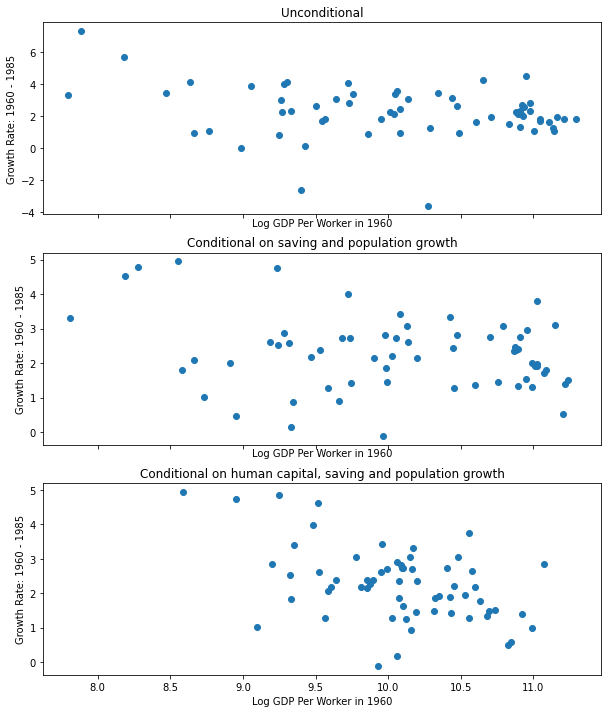

In [23]:
fig, ax = plt.subplots(3, 1, sharex = 'col', figsize = (10, 12))
ax[0].scatter(data_d['logy60'], (data_d['logy85'] - data_d['logy60'])*100/25)
ax[0].set_xlabel('Log GDP Per Worker in 1960')
ax[0].set_ylabel('Growth Rate: 1960 - 1985')
ax[0].set_title('Unconditional')


ax[1].scatter(residly601 + np.mean(data_d['logy60']), 
           (residgr1 + np.mean(data_d['logy85'] - data_d['logy60']))*100/25)
ax[1].set_xlabel('Log GDP Per Worker in 1960')
ax[1].set_ylabel('Growth Rate: 1960 - 1985')
ax[1].set_title('Conditional on saving and population growth')


ax[2].scatter(residly602 + np.mean(data_d['logy60']), 
           (residgr2 + np.mean(data_d['logy85'] - data_d['logy60']))*100/25)
ax[2].set_xlabel('Log GDP Per Worker in 1960')
ax[2].set_ylabel('Growth Rate: 1960 - 1985')
ax[2].set_title('Conditional on human capital, saving and population growth')
plt.show()